# Active Learning Notebook

Test out using [modAL](https://modal-python.readthedocs.io/en/latest/index.html) with PyMKS.

In [1]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do, merge_with
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence
from active import gsx_query, gsy_query, igs_query, multiple_rounds

## Generate Data Functions

Functions to generate the microstructure. The microstructures are stochastically generated from 6 nominal classes.

In [2]:
def shuffle(data):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=data.chunks)

def generate_x(shape, seed):
    da.random.seed(seed)
    np.random.seed(seed)

    tmp = [
        generate_multiphase(shape=shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=50, percent_variance=0.15)
        for x in [(15, 2), (2, 15), (7, 7), (9, 3), (3, 9), (2, 2)]
    ]
    return np.array(shuffle(da.concatenate(tmp)))

## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [3]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], x_data.shape[1], x_data.shape[2])
        )),
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=31, correlations=[(0, 1), (1, 1)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3, svd_solver='full')),
    )

In [4]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor),
    ))

def make_linear_model():
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3))
        ('regressor', LinearRegression()),
    ))

def pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [5]:
@curry
def oracle_from_data(shape, x_data):
    y_stress = solve_fe(x_data.reshape((-1,) + shape),
                        elastic_modulus=(1.3, 2.5),
                        poissons_ratio=(0.42, 0.35),
                        macro_strain=0.001)['stress'][..., 0]

    return np.array(da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1))

@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

## Helper Functions

In [6]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

## Set up the active learners

One is a GPR using the maximum std and the other is random

In [7]:
from active import make_igs, make_gsx, make_gsy, make_bayes, make_uncertainty, make_ensemble, make_random

distance_transformer = lambda x: pca_model().fit_transform(x)


def make_learners(x_train, y_train):
    return dict(
        uncertainty=make_uncertainty(make_gp_model, x_train, y_train),
        random=make_random(make_gp_model, x_train, y_train),
#        ensemble=make_ensemble(x_train, y_train),
        bayes=make_bayes(make_gp_model, x_train, y_train),
        gsx=make_gsx(distance_transformer)(make_gp_model, x_train, y_train),
        gsy=make_gsy(make_gp_model, x_train, y_train),
        gigs=make_igs(distance_transformer)(make_gp_model, x_train, y_train)
    )

## Generate the data

In [ ]:
grid_shape = (41, 41)
n_sample_per_class = 100
x_data = generate_x((n_sample_per_class,) + grid_shape, 5)
y_data = oracle_from_data(grid_shape, x_data)

In [8]:
np.save('x_data.npy', x_data)
np.save('y_data.npy', y_data)

NameError: name 'x_data' is not defined

In [8]:
grid_shape = (41, 41)
n_sample_per_class = 100
x_data = np.load('x_data.npy')
y_data = np.load('y_data.npy')

In [9]:
y_data.shape

(600,)

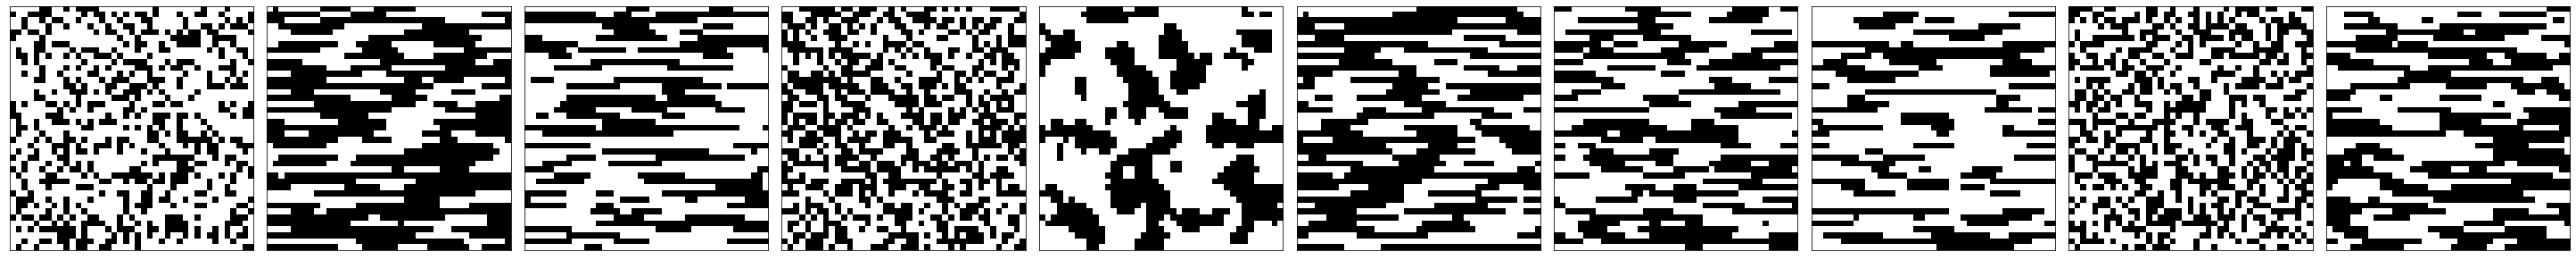

In [10]:
plot_microstructures(*x_data[:10], cmap='gray', colorbar=False);

## Run the learners

In [11]:
scores = multiple_rounds(x_data, y_data, 5, 100, make_learners, oracle_func, (0.8, 0.16))


evaluating uncertainty


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


evaluating random


100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


evaluating bayes


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


evaluating gsx


100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


evaluating gsy


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


evaluating gigs


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


evaluating uncertainty


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


evaluating random


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


evaluating bayes


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


evaluating gsx


100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


evaluating gsy


100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


evaluating gigs


100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


evaluating uncertainty


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


evaluating random


100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


evaluating bayes


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


evaluating gsx


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


evaluating gsy


100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


evaluating gigs


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


evaluating uncertainty


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


evaluating random


100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


evaluating bayes


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


evaluating gsx


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


evaluating gsy


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


evaluating gigs


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


evaluating uncertainty


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


evaluating random


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


evaluating bayes


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


evaluating gsx


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


evaluating gsy


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


evaluating gigs


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


(0.5, 1.0)

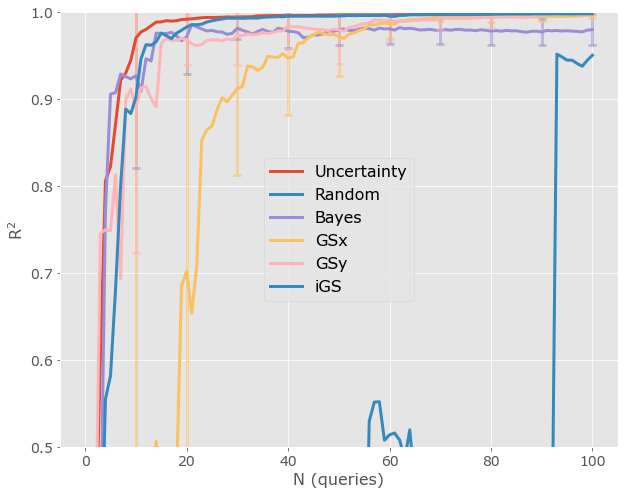

In [52]:
import matplotlib

plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
ax = plt.gca()
matplotlib.rc('font', **dict(size=16))
names = dict(
    uncertainty='Uncertainty',
    random="Random",
    bayes="Bayes",
    gsx='GSx',
    gsy='GSy',
    gigs='iGS'
)

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    p = ax.plot(x, y, label=names[k], lw=3)
#    print(p[-1].get_color())
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        xe, ye, ee = x[10::10], y[10::10], e[10::10]
        ax.errorbar(xe, ye, yerr=ee * 2, alpha=0.5, fmt='o', markersize=0, ecolor=p[-1].get_color(), elinewidth=3, capsize=4, capthick=3)
 #       ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend(fontsize=16)
plt.xlabel('N (queries)', fontsize=16)
plt.ylabel(r'$R^2$', fontsize=16);
plt.ylim(0.5, 1)

In [96]:
scores = multiple_rounds(x_data, y_data, 10, 100)

evaluating std


100%|██████████| 100/100 [1:17:36<00:00, 46.57s/it]   


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating std


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating random


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


evaluating bayes


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


evaluating gsx


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


evaluating std


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating random


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


evaluating bayes


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


evaluating gsx


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


evaluating igs


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


evaluating gsy


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]



## The results

(0.0, 1.0)

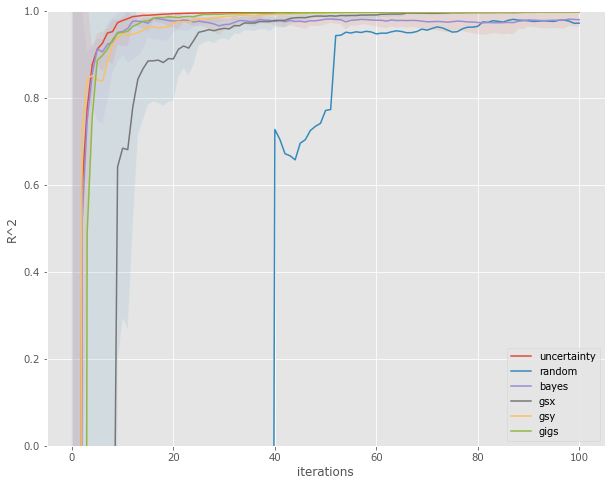

In [14]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0., 1)

(0.9, 1.0)

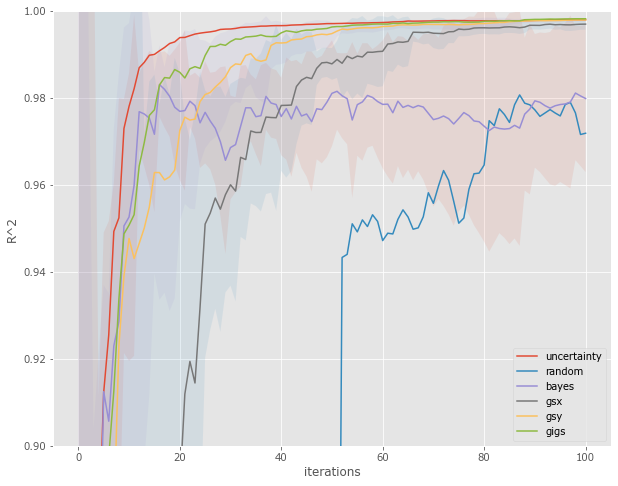

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.9, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

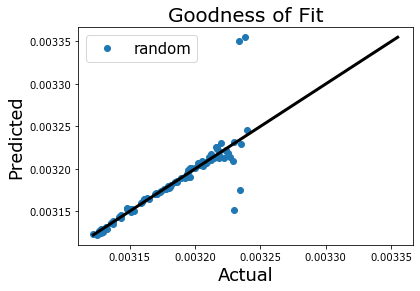

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

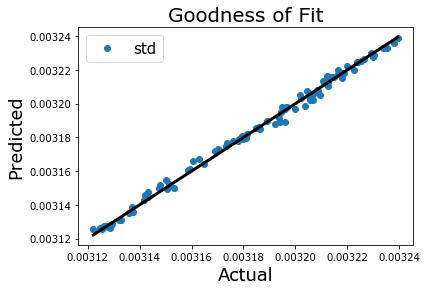

In [90]:
plot_parity(y_test, y_pred_std, label='std')